In [10]:
!pip install cvzone ultralytics

In [11]:
import cv2
from ultralytics import YOLO
import cvzone
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import keras
import random
from keras.layers import TFSMLayer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from IPython.display import display
from PIL import Image
import os
from google.colab.patches import cv2_imshow
from collections import Counter

In [12]:
classes = ['Amul_Ice_Cream', 'Cake', 'CeraVe', 'HnS_Shampoo', 'Nestle_Milk_Powder', 'Plum', 'Thums_Up', 'Wild_Stone']

In [13]:
base_prices = {
    'Amul_Ice_Cream': 30.0,
    'Cake': 30.0,
    'CeraVe': 900.0,
    'HnS_Shampoo': 250.0,
    'Nestle_Milk_Powder': 10.0,
    'Plum': 350.0,
    'Thums_Up': 20.0,
    'Wild_Stone': 70.0
}

In [14]:
from datetime import datetime

# Offers Dictionary: Festival seasons with date ranges and discount percentages
offers = {
    # Major Festival Seasons with Discounts
    'Republic Day': {
        'start_date': '2025-01-24',
        'end_date': '2025-01-26',
        'discount_percent': 10,
        'applicable_products': 'all'
    },
    'Holi': {
        'start_date': '2025-03-12',
        'end_date': '2025-03-15',
        'discount_percent': 20,
        'applicable_products': 'all'
    },
    'Independence Day': {
        'start_date': '2025-08-14',
        'end_date': '2025-08-16',
        'discount_percent': 10,
        'applicable_products': 'all'
    },
    'Raksha Bandhan': {
        'start_date': '2025-08-08',
        'end_date': '2025-08-10',
        'discount_percent': 12,
        'applicable_products': 'all'
    },
    'Ganesh Chaturthi': {
        'start_date': '2025-08-26',
        'end_date': '2025-08-28',
        'discount_percent': 18,
        'applicable_products': 'all'
    },
    'Dussehra': {
        'start_date': '2025-10-01',
        'end_date': '2025-10-03',
        'discount_percent': 20,
        'applicable_products': 'all'
    },
    'Diwali': {
        'start_date': '2025-10-18',
        'end_date': '2025-10-23',
        'discount_percent': 25,
        'applicable_products': 'all'
    },
    'Christmas': {
        'start_date': '2025-12-24',
        'end_date': '2025-12-26',
        'discount_percent': 5,
        'applicable_products': 'all'
    },
    'New Year': {
        'start_date': '2025-12-30',
        'end_date': '2026-01-02',
        'discount_percent': 8,
        'applicable_products': 'all'
    },

    # Summer Season: Price increase for specific cold products
    'Summer Season': {
        'start_date': '2025-03-15',
        'end_date': '2025-06-30',
        'discount_percent': -15,  # Negative means price INCREASE
        'applicable_products': ['Amul_Ice_Cream', 'Thums_Up']
    }
}

In [15]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


# Change directory to where your data folder is located
os.chdir('/content/drive/MyDrive/Smart Retail Checkout')

Mounted at /content/drive


In [16]:
def check_active_offers(current_date=None):
    if current_date is None:
        current_date = datetime.now().date()
    else:
        current_date = datetime.strptime(current_date, '%Y-%m-%d').date()

    active_offers = []

    for festival, details in offers.items():
        start = datetime.strptime(details['start_date'], '%Y-%m-%d').date()
        end = datetime.strptime(details['end_date'], '%Y-%m-%d').date()

        if start <= current_date <= end:
            active_offers.append({
                'festival': festival,
                'discount_percent': details['discount_percent'],
                'applicable_products': details['applicable_products']
            })

    return active_offers

In [17]:
def apply_offers(prices, active_offers):
    updated_prices = prices.copy()

    for offer in active_offers:
        discount_percent = offer['discount_percent']
        applicable_products = offer['applicable_products']

        if applicable_products == 'all':
            affected_products = updated_prices.keys()
        else:
            affected_products = applicable_products

        for product in affected_products:
            if product in updated_prices:
                base_price = updated_prices[product]
                updated_price = base_price * (1 - discount_percent / 100)
                updated_prices[product] = round(updated_price, 2)

    return updated_prices

In [18]:
present_prices = apply_offers(base_prices, check_active_offers())

In [19]:
combos = {
    'Snack Combo': {
        'items': ['Amul_Ice_Cream', 'Thums_Up'],
        'discount_percent': 3
    },
    'Breakfast Combo': {
        'items': ['Nestle_Milk_Powder', 'Cake'],
        'discount_percent': 4
    },
    'Personal Care Combo': {
        'items': ['HnS_Shampoo', 'Plum', 'CeraVe'],
        'discount_percent': 15
    }
}

In [20]:
cnn_model = load_model('full_model.keras')

In [21]:
def convert_webp_to_jpg(webp_path, output_folder='Converted_Images'):
    os.makedirs(output_folder, exist_ok=True)
    img = Image.open(webp_path).convert('RGB')  # Convert to RGB
    base_name = os.path.basename(webp_path)
    jpg_name = os.path.splitext(base_name)[0] + '.jpg'
    output_path = os.path.join(output_folder, jpg_name)
    img.save(output_path, 'JPEG')
    print(f"Converted {webp_path} to {output_path}")
    return output_path

In [22]:
def make_square_with_padding(image):
    """Convert rectangular image to square with white padding."""
    h, w, _ = image.shape
    max_side = max(h, w)

    # Create white square canvas
    square_img = np.ones((max_side, max_side, 3), dtype=np.uint8) * 255

    # Calculate centering offsets
    x_center = (max_side - w) // 2
    y_center = (max_side - h) // 2

    # Place original image in center
    square_img[y_center:y_center+h, x_center:x_center+w] = image

    return square_img

In [23]:
def box_area(box):
    x1, y1, x2, y2 = box
    return max(0, x2 - x1) * max(0, y2 - y1)

def calculate_iou(boxA, boxB):
    # compute intersection
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = box_area(boxA)
    boxBArea = box_area(boxB)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [24]:
def detect_objects_yolo(image_path, yolo_model_path='yolov8m.pt'):
    """
    Detects objects using YOLO and returns the image with a list of bounding boxes.

    Args:
        image_path: Path to the input image
        yolo_model_path: Path to YOLO weights file

    Returns:
        img: Original image (numpy array)
        detections: List of dictionaries with bounding box info
                    Each dict contains: {'bbox': (x1, y1, x2, y2), 'confidence': conf, 'class_id': id}
    """
    # Load YOLO model
    yolo_model = YOLO(yolo_model_path)

    # Read image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image {image_path}")
        return None, []

    # Run YOLO detection
    results = yolo_model(img)

    # Extract bounding boxes
    detections = []
    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].int().tolist()
            conf = float(box.conf[0])
            class_id = int(box.cls[0])

            detections.append({
                'bbox': (x1, y1, x2, y2),
                'confidence': conf,
                'class_id': class_id
            })

    return img, detections

In [25]:
def remove_nested_boxes(detections, iou_threshold=0.7):
    filtered = []
    to_remove = set()

    for i, det_i in enumerate(detections):
        box_i = det_i['bbox']
        for j, det_j in enumerate(detections):
            if i == j:
                continue
            box_j = det_j['bbox']
            iou = calculate_iou(box_i, box_j)

            # If box_i is mostly inside box_j (IoU above threshold) and box_i is smaller,
            # mark box_i for removal (keep box_j)
            if iou > iou_threshold and box_area(box_i) < box_area(box_j):
                to_remove.add(i)
                break

    for k, det in enumerate(detections):
        if k not in to_remove:
            filtered.append(det)

    return filtered

In [26]:
def classify_detected_objects(img, detections, cnn_model, classes):
    """
    Given an image and detections from YOLO, classify each detected object using the CNN model.

    Args:
        img: The original image (numpy array)
        detections: List of detection dicts from YOLO with keys 'bbox', 'confidence', 'class_id'
        cnn_model: Your CNN model loaded and ready to predict
        classes: List of class names corresponding to CNN output classes

    Returns:
        predictions: List of tuples (predicted_class_name, confidence_score, bbox)
    """
    predictions = []
    img_with_boxes = img.copy()

    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        crop = img[y1:y2, x1:x2]

        # Preprocess crop: make square, resize, normalize, batch dimension
        padded_crop = make_square_with_padding(crop)
        resized_crop = cv2.resize(padded_crop, (224, 224))
        normalized_crop = resized_crop / 255.0
        input_img = np.expand_dims(normalized_crop, axis=0)

        # CNN prediction
        pred = cnn_model.predict(input_img)
        pred_idx = np.argmax(pred)
        pred_conf = np.max(pred)
        pred_class = classes[pred_idx]

        # Store prediction
        predictions.append((pred_class, pred_conf, det['bbox']))

        print(f"Detected object classified as {pred_class} with confidence {pred_conf:.2f}")

        # Draw rectangle on image
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{pred_class}: {pred_conf:.2f}"
        # Put the label above the bounding box
        cv2.putText(img_with_boxes, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display image with bounding boxes and labels using Colab-compatible function
    cv2_imshow(img_with_boxes)

    return predictions

In [27]:
def count_items_above_confidence(predictions, threshold=0.8):
    """
    Count detected item classes with confidence above the given threshold.

    Args:
        predictions: List of tuples (predicted_class_name, confidence_score, bbox)
        threshold: Minimum confidence score to count the item

    Returns:
        item_counts: Dictionary with class names as keys and counts as values
    """
    item_counts = {}
    for pred_class, pred_conf, _ in predictions:
        if pred_conf > threshold:
            item_counts[pred_class] = item_counts.get(pred_class, 0) + 1
    return item_counts

In [28]:
def validate_and_update_item_count(predictions, item_counts, classes):
    """
    Validate if the sum of item_counts matches the total number of predictions.
    If not equal, ask user to input missing items and update item_counts.

    Args:
        predictions: List of tuples (predicted_class_name, confidence_score, bbox)
        item_counts: Dictionary with class names as keys and counts as values
        classes: List of valid class names to check against user input

    Returns:
        item_counts: Updated dictionary with all items counted
    """
    total_predictions = len(predictions)
    total_counted = sum(item_counts.values())

    print(f"Total predictions: {total_predictions}")
    print(f"Total counted items: {total_counted}")

    if total_predictions == total_counted:
        print("All items accounted for!")
        return item_counts
    else:
        missing_count = total_predictions - total_counted
        print(f"Missing {missing_count} item(s)")

        print("\nEnter the missing items (format: 'class_name count'):")
        print("Example: CareVe 1, Plum 3")

        user_input = input("Missing items: ").strip()

        if user_input:
            items = user_input.split(',')
            for item in items:
                parts = item.strip().split()
                if len(parts) >= 2:
                    class_name = ' '.join(parts[:-1])
                    if class_name not in classes:
                        print(f"'{class_name}' not found in known classes. Skipping.")
                        continue
                    try:
                        count = int(parts[-1])
                        item_counts[class_name] = item_counts.get(class_name, 0) + count
                        print(f"Added {count} {class_name}(s)")
                    except ValueError:
                        print(f"Invalid format for '{item}'. Skipping.")

        total_counted = sum(item_counts.values())
        if total_predictions == total_counted:
            print(f"Updated successfully! Total items: {total_counted}")
        else:
            print(f"Warning: Still {total_predictions - total_counted} item(s) unaccounted for")

In [29]:
def handle_combo_offers(item_counts, combos, classes):
    """
    Checks for partially bought combos, shows discount offers, and allows user to add missing items.

    Args:
        item_counts: Dictionary with class names as keys and counts as values
        combos: Dictionary where keys are combo names and values are dicts with:
                'items': list of class names in the combo,
                'discount_percent': discount percent
        classes: List of all valid class names

    Returns:
        Updated item_counts dictionary
    """
    for combo_name, combo_details in combos.items():
        combo_items = combo_details.get('items', [])
        discount = combo_details.get('discount_percent', 0)

        # Validate combo_items is a list
        if not isinstance(combo_items, list):
            print(f"Warning: Combo '{combo_name}' items are not a list. Skipping.")
            continue

        # Check which combo items are present and which are missing
        present_items = [item for item in combo_items if item_counts.get(item, 0) > 0]
        missing_items = [item for item in combo_items if item_counts.get(item, 0) == 0]

        # If some items are present but not all, show the offer
        if len(present_items) > 0 and len(missing_items) > 0:
            print(f"\n{'='*60}")
            print(f"Combo: {combo_name}")
            print(f"Combo items: {', '.join(combo_items)}")
            print(f"Items you have: {', '.join(present_items)}")
            print(f"Items missing: {', '.join(missing_items)}")
            print(f"Special Offer: {discount}% discount if you complete this combo!")
            print(f"{'='*60}")

            add_combo = input("Do you want to add the missing items to complete this combo? (yes/no): ").strip().lower()

            if add_combo in ('yes', 'y'):
                for missing_item in missing_items:
                    # Validate class exists
                    if missing_item not in classes:
                        print(f"ERROR: '{missing_item}' not found in valid classes. Skipping.")
                        continue

                    # Ask for quantity
                    while True:
                        try:
                            quantity = int(input(f"Enter quantity for '{missing_item}': "))
                            if quantity < 0:
                                print("Please enter a non-negative number.")
                                continue
                            break
                        except ValueError:
                            print("Invalid input. Please enter an integer.")

                    if quantity > 0:
                        item_counts[missing_item] = item_counts.get(missing_item, 0) + quantity
                        print(f"Added {quantity} {missing_item}(s)")

                print(f"Combo '{combo_name}' completed! {discount}% discount applied.\n")

In [30]:
def generate_bill(item_counts, prices, combos):
    from PIL import Image, ImageDraw, ImageFont

    # Calculate individual item costs and total before discount
    item_lines = []
    total_before_discount = 0
    for item, count in item_counts.items():
        price = prices.get(item, 0)
        cost = count * price
        total_before_discount += cost
        item_lines.append({'item': item, 'count': count, 'price': price, 'cost': cost})

    # Track combos applied
    combo_savings = 0
    combo_lines = []

    # Track items used in combos for calculation
    used_item_counts = {item: 0 for item in item_counts}

    # Calculate dynamic column width based on longest item name
    max_item_length = max(len(item) for item in item_counts) if item_counts else 15
    item_col_width = max(20, max_item_length + 2)

    # Print Individual Items
    print("\nIndividual Items:")
    print(f"{'Item':<{item_col_width}} {'Count':>10} {'Price':>10} {'Cost':>10}")
    print("-" * (item_col_width + 40))
    for line in item_lines:
        print(f"{line['item']:<{item_col_width}}"
              f"{line['count']:>10} "
              f"{line['price']:>9.2f} Rs "
              f"{line['cost']:>10.2f} Rs")

    # Check combos and calculate discounts
    for combo_name, combo_details in combos.items():
        combo_items = combo_details.get('items', [])
        discount_percent = combo_details.get('discount_percent', 0)

        # Check if all combo items are present with at least 1 count
        if all(item_counts.get(item, 0) > 0 for item in combo_items):
            # Calculate cost of combo items (full counts)
            combo_cost = 0
            min_count = min(item_counts.get(item, 0) for item in combo_items)
            for item in combo_items:
                price = prices.get(item, 0)
                combo_cost += min_count * price
                used_item_counts[item] += min_count

            discount_amount = combo_cost * discount_percent / 100
            combo_savings += discount_amount

            combo_lines.append({
                'combo_name': combo_name,
                'combo_cost': combo_cost,
                'discount_percent': discount_percent,
                'discount_amount': discount_amount,
                'cost_after_discount': combo_cost - discount_amount
            })

    # Show combos
    if combo_lines:
        print("\nCombos Applied:")
        print("-" * 60)
        for combo in combo_lines:
            print(f"{combo['combo_name']} - {combo['discount_percent']}% off")
            print(f"  Cost before discount: ₹{combo['combo_cost']:.2f}")
            print(f"  Discount amount:      -₹{combo['discount_amount']:.2f}")
            print(f"  Cost after discount:  ₹{combo['cost_after_discount']:.2f}")

    # Calculate leftover items cost (items not fully used in combos)
    leftover_cost = 0
    leftover_items = []
    for item, count in item_counts.items():
        used_count = used_item_counts.get(item, 0)
        leftover_count = count - used_count
        if leftover_count > 0:
            price = prices.get(item, 0)
            cost = leftover_count * price
            leftover_cost += cost
            leftover_items.append({'item': item, 'count': leftover_count, 'price': price, 'cost': cost})

    if leftover_items:
        print("\nRemaining Items (Outside Combos):")
        print(f"{'Item':<{item_col_width}} {'Count':>8} {'Price':>10} {'Cost':>10}")
        print("-" * (item_col_width + 8 + 10 + 12))
        for item_data in leftover_items:
            print(f"{item_data['item']:<{item_col_width}}"
                  f"{item_data['count']:>8} "
                  f"{item_data['price']:>9.2f} Rs "
                  f"{item_data['cost']:>10.2f} Rs")

    # Final total
    total_after_discount = total_before_discount - combo_savings
    print("\n" + "=" * (item_col_width + 8 + 10 + 12))
    print(f"{'TOTAL BILL:':<{item_col_width}}{'':>8}{'':>10}₹{total_after_discount:>10.2f}")
    print("=" * (item_col_width + 8 + 10 + 12) + "\n")

    return total_after_discount, combo_lines, used_item_counts

In [ ]:
# for filename in os.listdir('Web_Images'):
#     if filename.lower().endswith('.webp'):
#         webp_path = os.path.join('Web_Images', filename)
#         convert_webp_to_jpg(webp_path, output_folder='Sample_Images')

In [36]:
folder_path = "Sample_Images"
image_extensions = ('.jpg', '.jpeg', '.png')

images = [f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]

if images:
    random_image = random.choice(images)
    random_image_path = os.path.join(folder_path, random_image)
    print(f"Using random image: {random_image_path}")
else:
    print("No image files found in the folder.")

Using random image: Sample_Images/Test4.jpg



0: 640x480 2 bottles, 48.8ms
Speed: 2.4ms preprocess, 48.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Detected object classified as Plum with confidence 0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Detected object classified as CeraVe with confidence 1.00


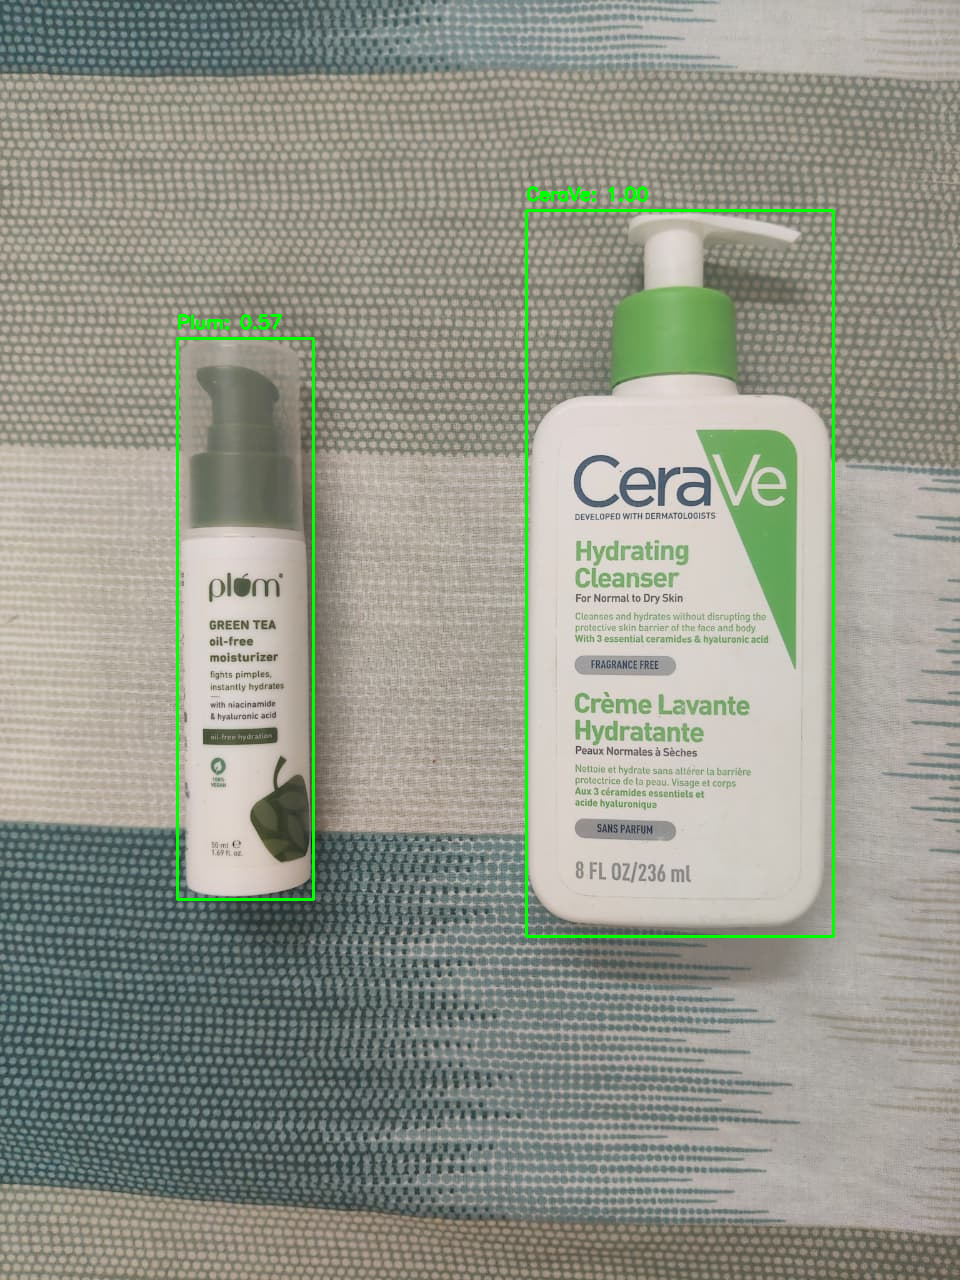

In [37]:
# 1. Detect objects
img, detections = detect_objects_yolo(random_image_path, 'yolov8m.pt')

fil_detections = remove_nested_boxes(detections)

# 2. Classify detections
predictions = classify_detected_objects(img, detections, cnn_model, classes)

# 3. Filter by confidence
item_counts = count_items_above_confidence(predictions, threshold=0.8)

In [38]:
# 4. Validate counts
validate_and_update_item_count(predictions, item_counts, classes)

Total predictions: 2
Total counted items: 1
Missing 1 item(s)

Enter the missing items (format: 'class_name count'):
Example: CareVe 1, Plum 3
Missing items: Plum 1
Added 1 Plum(s)
Updated successfully! Total items: 2


In [39]:
# 5. Handle combos
handle_combo_offers(item_counts, combos, classes)

# 6. Generate final bill
final_bill, applied_combos, item_usage = generate_bill(item_counts, present_prices, combos)


Combo: Personal Care Combo
Combo items: HnS_Shampoo, Plum, CeraVe
Items you have: Plum, CeraVe
Items missing: HnS_Shampoo
Special Offer: 15% discount if you complete this combo!
Do you want to add the missing items to complete this combo? (yes/no): yes
Enter quantity for 'HnS_Shampoo': 1
Added 1 HnS_Shampoo(s)
Combo 'Personal Care Combo' completed! 15% discount applied.


Individual Items:
Item                      Count      Price       Cost
------------------------------------------------------------
CeraVe                       1    900.00 Rs     900.00 Rs
Plum                         1    350.00 Rs     350.00 Rs
HnS_Shampoo                  1    250.00 Rs     250.00 Rs

Combos Applied:
------------------------------------------------------------
Personal Care Combo - 15% off
  Cost before discount: ₹1500.00
  Discount amount:      -₹225.00
  Cost after discount:  ₹1275.00

TOTAL BILL:                           ₹   1275.00

